In [ ]:
# run to get dataset
! git clone https://github.com/YunfeiZHAO/transfer-learning.git
# lets install torch again if the session expired
!pip3 install torch torchvision

Cloning into 'transfer-learning'...
remote: Enumerating objects: 10834, done.
remote: Total 10834 (delta 0), reused 0 (delta 0), pack-reused 10834
Receiving objects: 100% (10834/10834), 385.40 MiB | 50.86 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Checking out files: 100% (10813/10813), done.


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

from skimage import io, transform
from skimage.io import imread, imshow
import pandas as pd

import cv2 


In [ ]:
im = imread("./transfer-learning/DatabaseClassif/Images/00002302_01_U.png")    

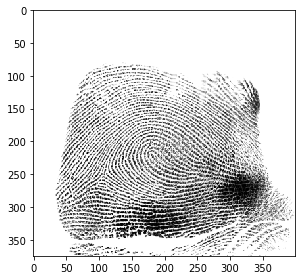

In [ ]:
imshow(im)

# Preprocessing

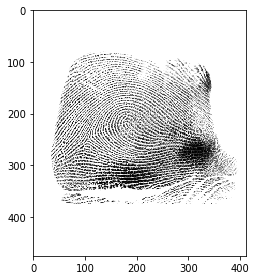

In [ ]:
"""Center """
#Code : Compute center of gravity (cog)
def compute_cog(in_im, bkg_val=255):
    count = (in_im != bkg_val).sum()
    y_center, x_center = np.argwhere(in_im != bkg_val).sum(0) / count
    return int(y_center), int(x_center)
	
#Code : Center image around center of gravity
def center_im(in_im, in_cog_yx, in_value=255):
    ''' center image on input point
        :param in_im: np image
        :param in_cog_yx: point used to center image
        :param in_value: output value when pixels are added to input image
        :return: centered image
        '''
    in_size_y = in_im.shape[0]  # hauteur
    in_size_x = in_im.shape[1]  # largeur

    new_size_y = 2 * max(in_cog_yx[0], in_size_y - in_cog_yx[0])
    new_size_x = 2 * max(in_cog_yx[1], in_size_x - in_cog_yx[1])
    out_im = in_value * np.ones([new_size_y, new_size_x]).astype(np.uint8)

    out_cog_yx = [int(new_size_y/2), int(new_size_x/2)]
    beginy = out_cog_yx[0] - in_cog_yx[0]
    endy = out_cog_yx[0] + (in_size_y - in_cog_yx[0])
    beginx = out_cog_yx[1] - in_cog_yx[1]
    endx = out_cog_yx[1] + (in_size_x - in_cog_yx[1])
    out_im[beginy:endy, beginx:endx] = in_im
    return out_im
def test(X):
    #Code : Combine COG & Center Image
    ycog, xcog = compute_cog(X, bkg_val= 255) #bkg_val background_value
    im = center_im(X, [ycog, xcog], in_value=255)
    return im

X = imread("./transfer-learning/DatabaseClassif/Images/00002302_01_U.png")
im = test(X)
imshow(im)

Resized Dimensions :  (255, 313)


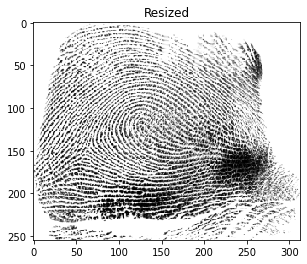

In [ ]:
"""Center """
#Code : Compute center of gravity (cog)
def compute_cog(in_im, bkg_val=255):
    count = (in_im != bkg_val).sum()
    y_center, x_center = np.argwhere(in_im != bkg_val).sum(0) / count
    return int(y_center), int(x_center)
	
#Code : Center image around center of gravity
def center_im(in_im, in_cog_yx, in_value=255):
    ''' center image on input point
        :param in_im: np image
        :param in_cog_yx: point used to center image
        :param in_value: output value when pixels are added to input image
        :return: centered image
        '''
    in_size_y = in_im.shape[0]  # hauteur
    in_size_x = in_im.shape[1]  # largeur

    new_size_y = 2 * max(in_cog_yx[0], in_size_y - in_cog_yx[0])
    new_size_x = 2 * max(in_cog_yx[1], in_size_x - in_cog_yx[1])
    out_im = in_value * np.ones([new_size_y, new_size_x]).astype(np.uint8)

    out_cog_yx = [int(new_size_y/2), int(new_size_x/2)]
    beginy = out_cog_yx[0] - in_cog_yx[0]
    endy = out_cog_yx[0] + (in_size_y - in_cog_yx[0])
    beginx = out_cog_yx[1] - in_cog_yx[1]
    endx = out_cog_yx[1] + (in_size_x - in_cog_yx[1])
    out_im[beginy:endy, beginx:endx] = in_im
    return out_im

def preprocessing(X, size=255):
    #Code : Combine COG & Center Image
    ycog, xcog = compute_cog(X, bkg_val= 255) #bkg_val background_value
    X = center_im(X, [ycog, xcog], in_value=255)

    """Extract redundant white background"""
    # (1) Convert to gray, and threshold
    #gray = cv2.cvtColor(X, cv2.COLOR_BGR2GRAY)
    th, threshed = cv2.threshold(X, 240, 255, cv2.THRESH_BINARY_INV)

    # (2) Morph-op to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

    # (3) Find the max-area contour
    cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    cnt = sorted(cnts, key=cv2.contourArea)[-1]

    # (4) Crop 
    x,y,w,h = cv2.boundingRect(cnt)
    X = X[y:y+h, x:x+w]

    """Resize"""
    # Set the expected size of image
    # Pick the shorter side 
    expected_height = size
    expected_width = size
    if X.shape[0] < X.shape[1]:
        X = cv2.resize(X, (int(X.shape[1] * expected_height / X.shape[0]), expected_height), interpolation=cv2.INTER_NEAREST)
    else:
        X = cv2.resize(X, (expected_width, int(X.shape[0] * expected_width / X.shape[1])), interpolation=cv2.INTER_NEAREST)
    return X

X = imread("./transfer-learning/DatabaseClassif/Images/00002302_01_U.png")
X = preprocessing(X)
print('Resized Dimensions : ', X.shape)
plt.figure("Resized")
plt.title('Resized')
plt.imshow(X, cmap = 'gray', interpolation = 'nearest')


# Load Data

In [ ]:
class FingerPrinterDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file, sep=" ", header=None)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx]
        landmarks = np.array(landmarks[1])
        sample = {'image': image, 'landmarks': landmarks}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
landmarks_frame = pd.read_csv('./transfer-learning/TP2_Cog_TrainEvalLists/db_all_eval.txt')

In [ ]:
FingerPrinterDataset = FingerPrinterDataset('./transfer-learning/TP2_Cog_TrainEvalLists/db_all_eval.txt', './transfer-learning/DatabaseClassif/Images', transform=None)

In [ ]:
FingerPrinterDataset. __getitem__(20)

{'image': array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8),
 'landmarks': array(20)}

In [ ]:
im = FingerPrinterDataset. __getitem__(100)['image']

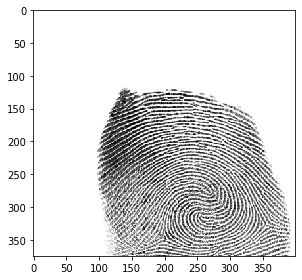

In [ ]:
imshow(im)

In [ ]:
class Center_Crop(object):
    """Do the preprocessing of the image.
        center the image
        crop and resize to the image with min length to given size
    """

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        image = preprocessing(image)
        return {'image': image, 'landmarks': landmarks}

In [ ]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = (output_size, output_size)

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        image = image[top: top + new_h,
                      left: left + new_w]
        return {'image': image, 'landmarks': landmarks}

In [ ]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        # print(image)
        # print(landmarks)
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        img = np.expand_dims(image, axis=0)
        # print(img.dtype)
        img = torch.from_numpy(img).type(torch.FloatTensor).div(255)
        # extend one color road to three color road
        img = img.repeat(3, 1, 1)
        return {'image': img,
                'landmarks': torch.from_numpy(landmarks)}

In [ ]:
class Normalize(object):
    """Normalise tensor"""
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
        return {'image': img,
                'landmarks': landmarks}

In [ ]:
test_dataset = FingerPrinterDataset(csv_file='./transfer-learning/TP2_Cog_TrainEvalLists/db_all_eval.txt',
                                           root_dir='./transfer-learning/DatabaseClassif/Images',
                                           transform=transforms.Compose([
                                                Center_Crop(),
                                                # RandomCrop(224),
                                                # ToTensor(),
                                                # Normalize()
                                           ]))

In [ ]:
for i_batch, sample_batched in enumerate(test_dataset):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())
    print(sample_batched['landmarks'])
    break

TypeError: ignored

In [ ]:
sample_batched['image']

tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 0.1597, 0.4679],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 1.8037, 1.2728],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 1.8037, 1.2728]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 0.2927, 0.6078],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 1.9734, 1.4307],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 1.9734, 1.4307]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        Center_Crop(),
        RandomCrop(224),
        ToTensor(),
        Normalize(),
    ]),
    'val': transforms.Compose([
        Center_Crop(),
        RandomCrop(224),
        ToTensor(),
        Normalize(),
    ]),
}

data_dir = './transfer-learning/DatabaseClassif/Images'
label_dir = './transfer-learning/TP2_Cog_TrainEvalLists'
image_datasets = {}
image_datasets['train'] = FingerPrinterDataset(
    csv_file=os.path.join(label_dir,'db_all_train.txt'),
    root_dir=data_dir,
    transform=data_transforms['train'])
image_datasets['val'] = FingerPrinterDataset(
    csv_file=os.path.join(label_dir,'db_all_eval.txt'),
    root_dir=data_dir,
    transform=data_transforms['val'])

################################# Batch property ###############################
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24,
                                             shuffle=True, num_workers=8)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)

Using device cuda:0


In [ ]:
 for sample in dataloaders["train"]:
    print(sample["image"])
    print(sample["landmarks"])
    break

In [ ]:
sample["image"].size()

torch.Size([24, 3, 224, 224])

In [ ]:
sample["landmarks"].size()

torch.Size([24])

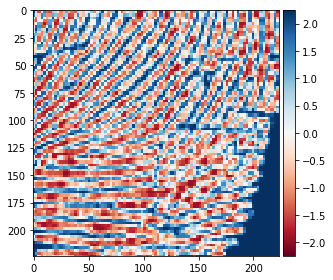

In [ ]:
imshow(sample["image"][0][0].numpy())

In [ ]:
sample["image"][0][0].numpy()

array([[ 1.5981677 ,  1.5981677 ,  1.7351656 , ..., -1.9295317 ,
        -1.9295317 , -1.9295317 ],
       [ 2.1632845 ,  2.1632845 ,  0.50218344, ..., -1.7582842 ,
        -1.7582842 , -1.7582842 ],
       [ 2.1632845 ,  2.1632845 ,  0.50218344, ..., -1.7582842 ,
        -1.7582842 , -1.7582842 ],
       ...,
       [ 2.2489083 ,  2.2489083 ,  1.3241715 , ...,  2.2489083 ,
         2.2489083 ,  2.2489083 ],
       [ 2.2489083 ,  2.2489083 ,  1.3241715 , ...,  2.2489083 ,
         2.2489083 ,  2.2489083 ],
       [ 2.2489083 ,  2.2489083 ,  2.060536  , ...,  2.2489083 ,
         2.2489083 ,  2.2489083 ]], dtype=float32)

In [ ]:
sample["image"][0][1].numpy()

array([[ 1.7633053 ,  1.7633053 ,  1.9033613 , ..., -1.8431373 ,
        -1.8431373 , -1.8431373 ],
       [ 2.3410363 ,  2.3410363 ,  0.64285725, ..., -1.6680672 ,
        -1.6680672 , -1.6680672 ],
       [ 2.3410363 ,  2.3410363 ,  0.64285725, ..., -1.6680672 ,
        -1.6680672 , -1.6680672 ],
       ...,
       [ 2.4285715 ,  2.4285715 ,  1.4831933 , ...,  2.4285715 ,
         2.4285715 ,  2.4285715 ],
       [ 2.4285715 ,  2.4285715 ,  1.4831933 , ...,  2.4285715 ,
         2.4285715 ,  2.4285715 ],
       [ 2.4285715 ,  2.4285715 ,  2.235994  , ...,  2.4285715 ,
         2.4285715 ,  2.4285715 ]], dtype=float32)

# Train model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, name='model'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_since = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        if epoch % 20 == 0:
            torch.save(model_conv.state_dict(), f'./{name}_{epoch}')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for  sample in dataloaders[phase]:
                inputs, labels = sample["image"], sample["landmarks"]
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        epoch_time = time.time() - epoch_since
        print(f'epoch {epoch} used time: {epoch_since}')
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Setting model

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2000)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# fixe conv layer
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2000)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Run model

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


KeyboardInterrupt: ignored

In [ ]:
torch.save(model_conv.state_dict(), './restnet50_fixe_nn')

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 7.8162 Acc: 0.0000
val Loss: 7.6030 Acc: 0.0005

Epoch 1/19
----------
train Loss: 7.7225 Acc: 0.0000
val Loss: 7.6029 Acc: 0.0005

Epoch 2/19
----------


KeyboardInterrupt: ignored